In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
np.random.seed(7)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train = pd.read_csv('./Desktop/tool-wear-detection-in-cnc-mill/train.csv')

train.head()

,No,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
0,1,wax,6,4.0,unworn,yes,yes
1,2,wax,20,4.0,unworn,yes,yes
2,3,wax,6,3.0,unworn,yes,yes
3,4,wax,6,2.5,unworn,no,NaN
4,5,wax,20,3.0,unworn,no,NaN


In [3]:
# Load all of the experiments

file = './Desktop/tool-wear-detection-in-cnc-mill/experiment_'

new_train = train.copy()

In [4]:
new_train['No'] = new_train['No'].apply(lambda x : file + '0'+str(x) if x<10 else file + str(x))

In [5]:
data = pd.DataFrame()
for i in new_train['No']:
    df = pd.read_csv(i+'.csv')
    df['tool_condition'] = new_train[new_train['No'] == i]['tool_condition']
    val=new_train[new_train['No'] == i]['tool_condition'].iloc[0]
    df['tool_condition'].fillna(value=val,inplace=True)
    data=pd.concat([data,df])

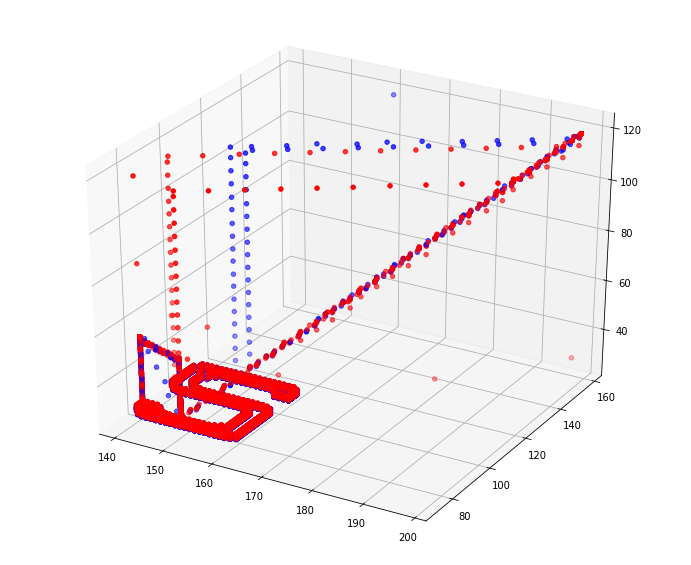

In [6]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(111,projection='3d')

ax.scatter(data['X1_ActualPosition'],data['Y1_ActualPosition'],data['Z1_ActualPosition'],
           c=data['tool_condition'].map({'worn':'r','unworn':'b'}))

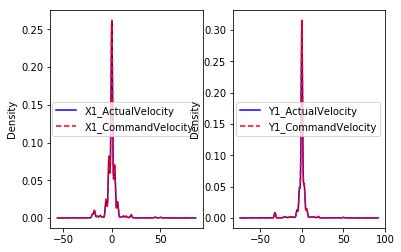

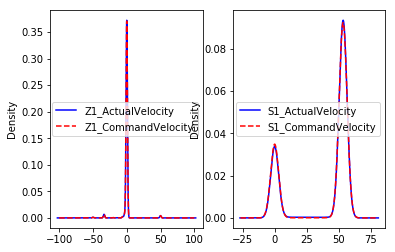

In [7]:
#Command Velocity , Actual Velocity
# X,Y,Z,S

plotting = ['X1','Y1','Z1','S1']

i = 0
for j in range(2):
    fig = plt.figure(j+1,figsize=(6,4))
    axis = fig.subplots(1,2)

    data[plotting[i]+'_ActualVelocity'].plot(kind='kde',ax=axis[0],c='b',)
    data[plotting[i]+'_CommandVelocity'].plot(kind='kde',ax=axis[0],c = 'r',ls='--',)
    
    data[plotting[i+1]+'_ActualVelocity'].plot(kind='kde',ax=axis[1],c='b')
    data[plotting[i+1]+'_CommandVelocity'].plot(kind='kde',ax=axis[1],c = 'r',ls='--')
    

    axis[0].legend([plotting[i]+'_ActualVelocity',plotting[i]+'_CommandVelocity'])
    axis[1].legend([plotting[i+1]+'_ActualVelocity',plotting[i+1]+'_CommandVelocity'])
    
    i+=2
    

plt.show()


In [8]:
new_data= data.drop(['M1_sequence_number','M1_CURRENT_PROGRAM_NUMBER','X1_ActualPosition',
          'X1_CurrentFeedback','Y1_CurrentFeedback','Z1_CurrentFeedback','S1_CurrentFeedback',
          'X1_DCBusVoltage','Y1_DCBusVoltage','Z1_DCBusVoltage','S1_DCBusVoltage','S1_CommandVelocity',
          'S1_CommandAcceleration','Y1_ActualPosition','Z1_CommandVelocity','Z1_CommandAcceleration',
          'X1_CommandVelocity','X1_CommandAcceleration','Y1_CommandVelocity','Y1_CommandAcceleration',
          'Z1_ActualPosition','X1_CommandPosition','Y1_CommandPosition',
          'Z1_CommandPosition','S1_ActualPosition','S1_CommandPosition'],axis = 1)

In [9]:
len(new_data.columns)

23

In [10]:
x_train, x_test, y_train, y_test = train_test_split(new_data.drop(['Machining_Process','tool_condition'],axis=1),
                                                    new_data['tool_condition'],test_size=0.2)

In [11]:
knn = KNeighborsClassifier(metric='euclidean',n_neighbors=3,n_jobs=-1)

knn.fit(x_train,y_train)

print(classification_report(knn.predict(x_test),y_test))

             precision    recall  f1-score   support

     unworn       0.62      0.60      0.61      2432
       worn       0.64      0.66      0.65      2626

avg / total       0.63      0.63      0.63      5058



In [12]:
standard = StandardScaler()

df = standard.fit_transform(new_data.drop(['Machining_Process','tool_condition'],axis=1)) 

In [13]:
x_train, x_test, y_train, y_test = train_test_split(df,new_data['tool_condition'],test_size=0.2)

In [14]:
knn = KNeighborsClassifier(metric='euclidean',n_neighbors=3,n_jobs=-1)

knn.fit(x_train,y_train)
print(classification_report(knn.predict(x_test),y_test))

             precision    recall  f1-score   support

     unworn       0.73      0.74      0.73      2375
       worn       0.76      0.75      0.76      2683

avg / total       0.75      0.75      0.75      5058



In [15]:
param = {'metric':['euclidean','manhattan','minkowski'],'n_neighbors':[1,3,5,7,9,11],'weights':['uniform','distance']}

knn = KNeighborsClassifier(n_jobs=-1)

new_knn = GridSearchCV(estimator=knn,param_grid=param)

new_knn.fit(x_train,y_train)
#new_knn.fit(a[:-int(0.2*len(data))],data['tool_condition'][:-int(0.2*len(data))].values)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'], 'n_neighbors': [1, 3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
new_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}

In [17]:
best_knn = KNeighborsClassifier(**new_knn.best_params_)

best_knn.fit(x_train,y_train)

print(classification_report(best_knn.predict(x_test),y_test))

             precision    recall  f1-score   support

     unworn       0.76      0.76      0.76      2405
       worn       0.78      0.78      0.78      2653

avg / total       0.77      0.77      0.77      5058



In [18]:


dtree = DecisionTreeClassifier(criterion='gini')

dtree.fit(x_train,y_train)


print(classification_report(dtree.predict(x_test),y_test))


             precision    recall  f1-score   support

     unworn       0.72      0.73      0.73      2377
       worn       0.76      0.75      0.76      2681

avg / total       0.74      0.74      0.74      5058



In [19]:

dtree_new = DecisionTreeClassifier()
params = {'max_leaf_nodes':np.arange(100,201,5),'criterion':['gini','entropy']}

dtree_grid = GridSearchCV(estimator=dtree_new,param_grid=params)

dtree_grid.fit(x_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_leaf_nodes': array([100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160,
       165, 170, 175, 180, 185, 190, 195, 200]), 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [20]:
dtree_grid.best_params_

{'criterion': 'gini', 'max_leaf_nodes': 200}

In [21]:
dtree_new = DecisionTreeClassifier(**dtree_grid.best_params_)

dtree_new.fit(x_train,y_train)
print(classification_report(dtree_new.predict(x_test),y_test))

             precision    recall  f1-score   support

     unworn       0.78      0.73      0.75      2559
       worn       0.74      0.78      0.76      2499

avg / total       0.76      0.76      0.76      5058



In [22]:
rfc = RandomForestClassifier()

rfc.fit(x_train,y_train)

print(classification_report(rfc.predict(x_test),y_test))

             precision    recall  f1-score   support

     unworn       0.81      0.73      0.77      2659
       worn       0.73      0.80      0.77      2399

avg / total       0.77      0.77      0.77      5058



In [23]:
rfc_new = RandomForestClassifier()
params = {'criterion':['gini','entropy'],'n_estimators':np.arange(1,100,5)}

rfc_grid = GridSearchCV(estimator=rfc_new,param_grid=params)

rfc_grid.fit(x_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'n_estimators': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
       86, 91, 96])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
rfc_grid.best_params_

{'criterion': 'entropy', 'n_estimators': 96}

In [25]:
rfc_new = RandomForestClassifier(**rfc_grid.best_params_)

rfc_new.fit(x_train,y_train)
print(classification_report(rfc_new.predict(x_test),y_test))

             precision    recall  f1-score   support

     unworn       0.79      0.79      0.79      2429
       worn       0.80      0.81      0.81      2629

avg / total       0.80      0.80      0.80      5058



In [26]:
support_vector = SVC(kernel='rbf',C=5,gamma=1.5)

support_vector.fit(x_train,y_train)

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [27]:
print(classification_report(support_vector.predict(x_test),y_test))

             precision    recall  f1-score   support

     unworn       0.70      0.76      0.73      2218
       worn       0.80      0.75      0.77      2840

avg / total       0.76      0.75      0.75      5058



In [28]:
np.random.seed(10)
model = Sequential()
model.add(Dense(64,input_shape=x_train.shape[1:],activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',metrics=['accuracy'],loss='binary_crossentropy')

In [29]:
y_train = y_train.map({'worn':1,'unworn':0})

In [30]:
y_test = y_test.map({'worn':1,'unworn':0})

In [31]:
history = model.fit(x_train,y_train,epochs=10,validation_split=0.2,verbose=2,batch_size=16)

Train on 16182 samples, validate on 4046 samples
Epoch 1/10
 - 1s - loss: 0.6006 - acc: 0.6356 - val_loss: 0.5420 - val_acc: 0.6955
Epoch 2/10
 - 1s - loss: 0.5344 - acc: 0.7042 - val_loss: 0.5207 - val_acc: 0.7197
Epoch 3/10
 - 1s - loss: 0.5164 - acc: 0.7147 - val_loss: 0.4991 - val_acc: 0.7306
Epoch 4/10
 - 1s - loss: 0.5049 - acc: 0.7247 - val_loss: 0.4932 - val_acc: 0.7425
Epoch 5/10
 - 1s - loss: 0.4968 - acc: 0.7295 - val_loss: 0.5029 - val_acc: 0.7133
Epoch 6/10
 - 1s - loss: 0.4916 - acc: 0.7333 - val_loss: 0.4894 - val_acc: 0.7360
Epoch 7/10
 - 1s - loss: 0.4864 - acc: 0.7382 - val_loss: 0.4869 - val_acc: 0.7373
Epoch 8/10
 - 1s - loss: 0.4825 - acc: 0.7449 - val_loss: 0.5158 - val_acc: 0.7111
Epoch 9/10
 - 1s - loss: 0.4793 - acc: 0.7451 - val_loss: 0.4838 - val_acc: 0.7484
Epoch 10/10
 - 1s - loss: 0.4747 - acc: 0.7479 - val_loss: 0.5021 - val_acc: 0.7333


In [32]:
style.use('ggplot')

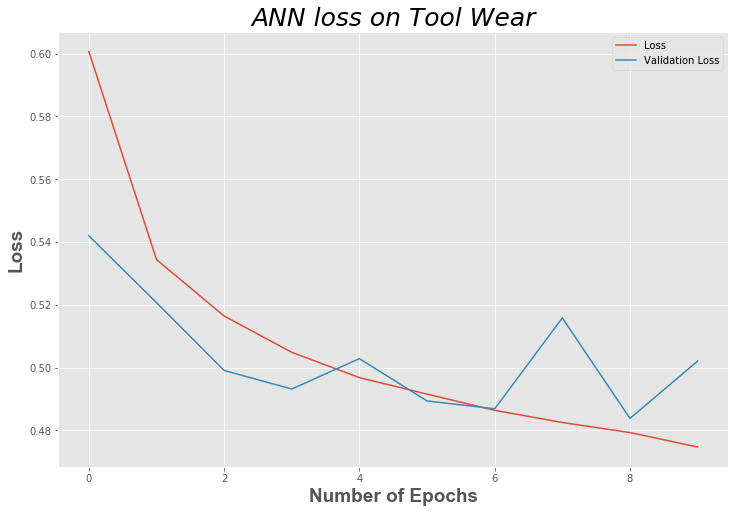

In [33]:
plt.figure(figsize=(12,8))
plt.plot(history.epoch,history.history['loss'],label='Loss')
plt.plot(history.epoch,history.history['val_loss'],label='Validation Loss')
plt.title('ANN loss on Tool Wear',fontsize=25,fontstyle='italic')
plt.xlabel('Number of Epochs',fontsize=19,fontname='Arial',weight='bold')
plt.ylabel('Loss',fontsize=19,fontname='Arial',weight='bold')
plt.legend()

In [34]:
print(classification_report(model.predict_classes(x_test),y_test))

             precision    recall  f1-score   support

          0       0.80      0.68      0.74      2817
          1       0.66      0.78      0.72      2241

avg / total       0.74      0.73      0.73      5058



(60, 90)

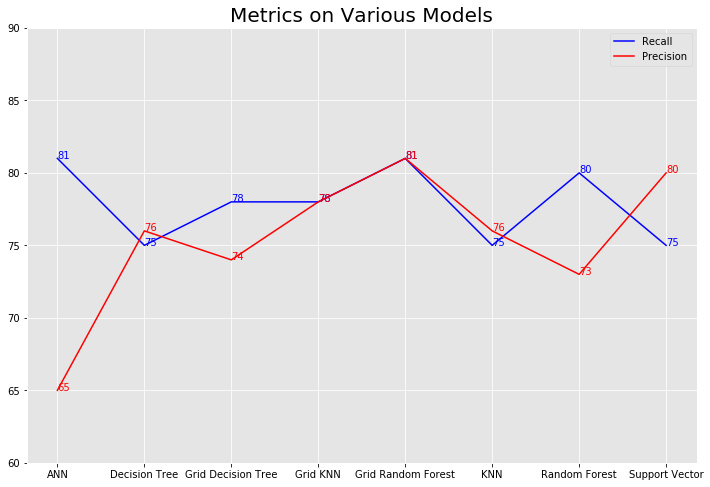

In [35]:
plt.figure(figsize=(12,8))


standard_recall = {'KNN':75,'Grid KNN':78,'Decision Tree':75,'Grid Decision Tree':78,'Random Forest':80,
                 'Grid Random Forest':81,'Support Vector':75, 'ANN':81}

standard_precision = {'KNN':76,'Grid KNN':78,'Decision Tree':76,'Grid Decision Tree':74,'Random Forest':73,
                 'Grid Random Forest':81,'Support Vector':80, 'ANN':65}


standard = pd.DataFrame(standard_recall,index=[1])
standard_prec = pd.DataFrame(standard_precision,index=[1])


plt.plot(standard.columns,standard.values[0],c='b',label="Recall")
plt.plot(standard_prec.columns,standard_prec.values[0],c='r',label='Precision')
for i in range(8):
    plt.annotate('%s'%standard.values[0][i],(i,standard.values[0][i]),color='blue',)
    plt.annotate('%s'%standard_prec.values[0][i],(i,standard_prec.values[0][i]),color='red')

plt.title('Metrics on Various Models',fontsize=20)
plt.legend()


plt.tick_params(colors='black')

plt.ylim((60,90))

